# Predicting likes of Youtube videos

**By Vaisakh Babu**

There is no need for an introduction to Youtube. It is one of the most popular video-sharing platform. Youtubers earn money from their videos. Here we have details on videos along with some features. Our objective is to accurately predict the number of likes for each video using the set of input variables. 

> **Motivation**: Knowing what all are the important features while uploading a video, youtubers can increase their number of views/likes of the video and hence increase their earnings.

## A quick look into our dataset

In [1]:
# Importing Libraries
import pandas as pd
import warnings
import numpy as np
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
# Loading the dataset
Dataframe = pd.read_csv('train.csv')
Dataframe.head(2)

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0


In [3]:
Dataframe.shape

(26061, 12)

**Our dataset has 26061 records and 12 columns.**

Lets see the columns in our dataset.

In [4]:
Dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       26061 non-null  int64  
 1   title          26061 non-null  object 
 2   channel_title  26061 non-null  object 
 3   category_id    26061 non-null  float64
 4   publish_date   26061 non-null  object 
 5   tags           26061 non-null  object 
 6   views          26061 non-null  float64
 7   dislikes       26061 non-null  float64
 8   comment_count  26061 non-null  float64
 9   description    26061 non-null  object 
 10  country_code   26061 non-null  object 
 11  likes          26061 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


**In our dataset first column is ID column and the last column is the target column. The remaining 10 columns are the features that we will use for our prediction.**

**In those 10 features, we can see that there are different kind of features. Numerical, categorical, textual and temporal features.**

In [5]:
COL = Dataframe.columns.tolist()

# ID column is the first column with the name 'video_id'
ID_COL = 'video_id'

# Target column is the last column, named 'likes'
TARGET_COL = 'likes'

# Numerical columns are : 'views','dislikes','comment_count'
NUM_COL = ['views','dislikes','comment_count']

# Categorical columns are : 'channel_title','category_id','country_code'
CAT_COL = ['channel_title','category_id','country_code']

# Textual columns are : 'title','tags','description'
TEXT_COL = ['title','tags','description']

# Temporal column is : 'publish_date'
TIME_COL = 'publish_date'

**We don't have any null values in our dataset. Now we can check the number of unique values in the columns**

In [6]:
Dataframe.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

## Hypotheses Generation

Now we know what are the columns in our dataset .We have 1 ID column, 1 target column, 3 numerical columns, 3 categorical columns, 3 textual columns and 1 temporal column. Now we will make some hypotheses

1. **Videos with more views get more likes**
2. **Videos with more comments get more likes**
3. **Videos with less dislikes get more likes**
4. **Descriptive videos get more number of likes**
5. **Channel affects the number of likes**
6. **Category of the video affects the number of likes**
7. **The country of origin affects the number of likes**
8. **People post more videos on weekends than weekdays**

## Exploratory data analysis

### Target Distribution

We have a regression problem in our hand. So, it is important to look into the target distribution. In our case it is the likes column.

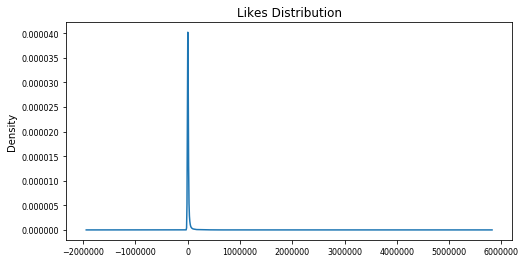

In [7]:
Dataframe[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=8, figsize=(8, 4));

**Right Skewed target distribution:**

We can see that the target distribution is highly skewed. In fact the distribution is **right skewed.**

We have to treat the data before building our model. Because, skewed data can cause less accurate prediction. That is, in this case we have less number of videos having a large number of likes. Therefore, our model won't be able to predict the videos that might having a large number of likes if we use this right skewed data.

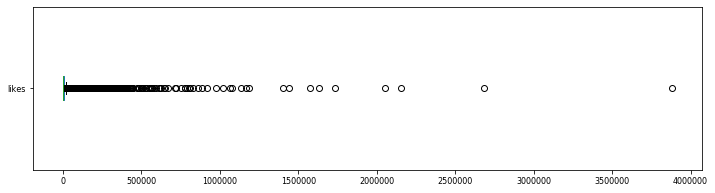

In [8]:
Dataframe[TARGET_COL].plot(kind='box', vert = False, fontsize=8, figsize=(12, 3));

The skewness is more evident form the boxplot. We can perform statistical test and skewness calculation for providing edidence for this. We can use **Shapiro–Wilk test** for testing the normal distribution.

In Shapiro–Wilk test, the null hypothesis is, the data is normally distributed and the significance level is 5%. Therefore, a p-value less than 0.05 can reject the null hypothesis. However if the p-value is greater than 0.05, then we cannot reject the null hypothesis.  

In [9]:
from scipy.stats import shapiro
data = Dataframe.likes
test = shapiro(data)
print('The p-value for the test is : {}'.format(test[1]))

The p-value for the test is : 0.0


**The p-value is less than the significant level. Therefor we can reject the null hypothesis.**


**Checking the skewness:**

In [10]:
Dataframe.likes.skew()

26.36605568219861

When the value of the skewness is positive, the tail of the distribution is longer towards the right hand side of the curve.

**We have to perform tarnsformation to our data in order to make the target distribution to be normal.**

**The distribution after log transformation to the data is :**

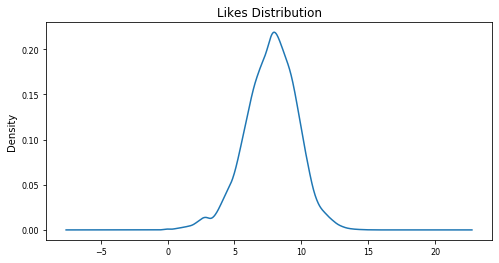

In [11]:
np.log1p(Dataframe[TARGET_COL]).plot(kind = 'density', title = 'Likes Distribution', fontsize=8, figsize=(8, 4));

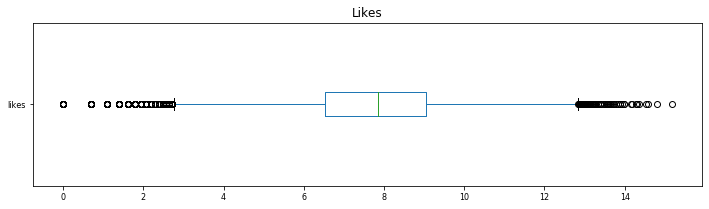

In [12]:
np.log1p(Dataframe[TARGET_COL]).plot(kind='box', vert = False, fontsize=8, figsize=(12, 3),title='Likes');

In [13]:
#Applying logerithmic transfomrations to target column of the dataset
Dataframe[TARGET_COL] = np.log1p(Dataframe[TARGET_COL])

### Unique values in each columns

The number of unique values in the dataframe are:

In [14]:
Dataframe.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

Let's check the number of nuique values in our categorical columns

In [15]:
Dataframe[CAT_COL].nunique()

channel_title    5764
category_id        17
country_code        4
dtype: int64

In [16]:
set(Dataframe.country_code)

{'CA', 'GB', 'IN', 'US'}

**In the column country_code, we have 4 unique values.**

|Code| Country |
|----|---------|
| CA | Canada  |
| GB | Britain |
| IN | India   |
| US | America |

**There are 5764 channels in the datasets and the videos are belongs to 17 categories**

## Univariate Analysis

We will analyse each features individually in univariate analysis.

1. **Numerical features**

In [17]:
Dataframe[NUM_COL].skew()

views            41.679872
dislikes         35.456527
comment_count    33.895410
dtype: float64

Our numerical columns are also skewed like the target variable.

**i) views**

In [18]:
# Function for plotting boxplot and kde plot
def plot1(df,title=' '):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    _ = df.plot(kind = 'box', ax=axes[0], vert=False, title = (title+' - boxplot').upper())
    _ = df.plot.kde(ax=axes[1], title = (title+' - density plot').upper())
    fig.show()

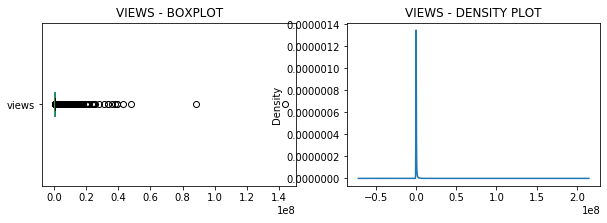

In [19]:
plot1(Dataframe[NUM_COL[0]],NUM_COL[0])

Let's tranform the data and see the distribution.

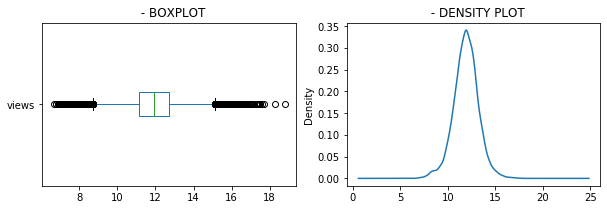

In [20]:
plot1(np.log1p(Dataframe[NUM_COL[0]]))

**ii) dislikes**

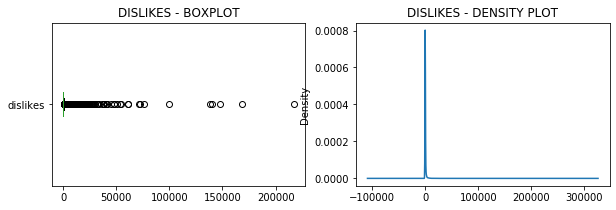

In [21]:
plot1(Dataframe[NUM_COL[1]],NUM_COL[1])

Applying logerithmic transformation:

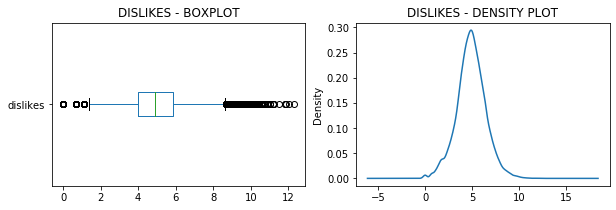

In [22]:
plot1(np.log1p(Dataframe[NUM_COL[1]]),NUM_COL[1])

**iii) comment_count**

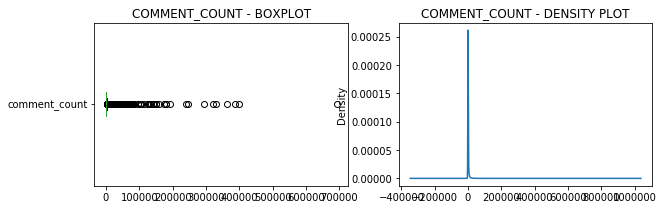

In [23]:
plot1(Dataframe[NUM_COL[2]],NUM_COL[2])

Applying logerithmic transformation:

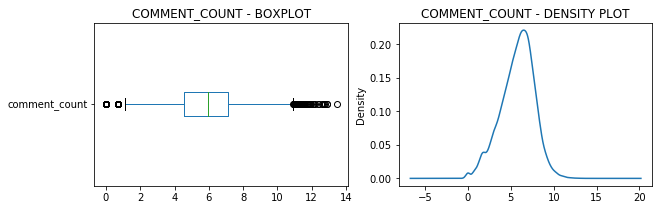

In [24]:
plot1(np.log1p(Dataframe[NUM_COL[2]]),NUM_COL[2])

In [25]:
#Applying logerithmic transfomrations to the numerical colums of the dataset
for i in NUM_COL:
    Dataframe[i] = np.log1p(Dataframe[i])

2. **Categorical features**

In [26]:
Dataframe[CAT_COL].nunique()

channel_title    5764
category_id        17
country_code        4
dtype: int64

We can see the number of videos in each categorical columns:

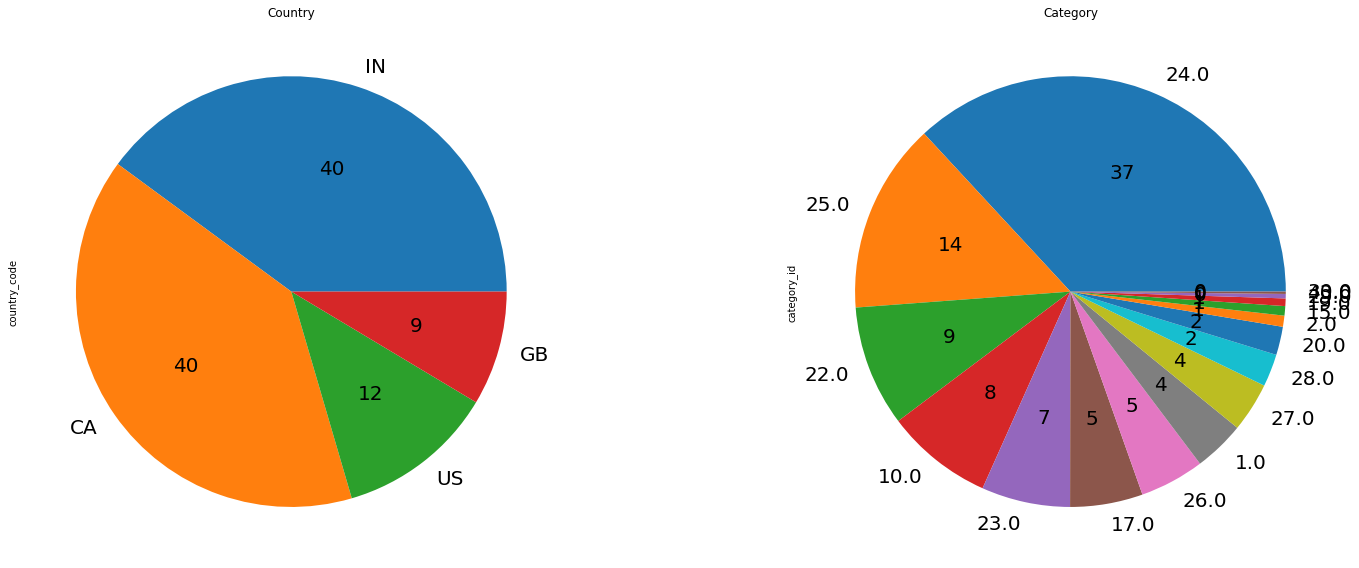

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
_ = Dataframe['country_code'].value_counts().plot(kind='pie', ax=axes[0], title='Country', autopct='%.0f', fontsize=20)
_ = Dataframe['category_id'].value_counts().plot(kind='pie', ax=axes[1], title='Category', autopct='%.0f', fontsize=20)
_ = plt.tight_layout()

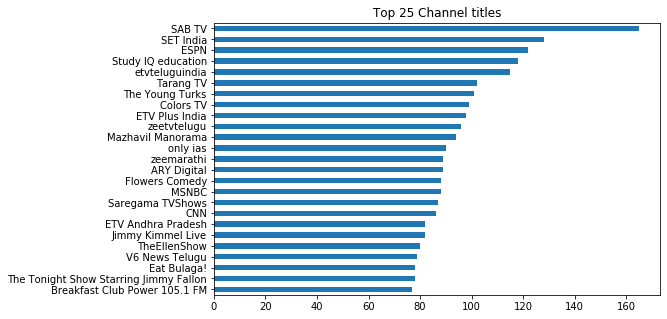

In [28]:
d1 = Dataframe['channel_title'].value_counts()[:25]
d1[::-1].plot.barh(figsize=(8,5),title='Top 25 Channel titles');

> From the pie chart, we can see that,
* India and Canada have highest number of videos: 40% each.
* 37% of videos are being uploaded in the category with id 24 and 14% with id 25.
* SAB TV, SET India, ESPN, Study IQ education and etvteluguindia are the channels with most number of videos.

In [29]:
for i in Dataframe['channel_title'].value_counts()[:5].index:
    print(i, " : ", Dataframe.query('channel_title=="{}"'.format(i))['country_code'].unique())

SAB TV  :  ['CA' 'IN']
SET India  :  ['IN' 'CA']
ESPN  :  ['US' 'GB' 'CA']
Study IQ education  :  ['IN']
etvteluguindia  :  ['IN']


3. **Textual features**

In [30]:
TEXT_COL

['title', 'tags', 'description']

In [31]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state=63)

#Function to show wordcloud
def plotWord(df,title='WordCloud'):
    op = wc.generate(str(df))
    plt.figure(figsize=(10,10))
    plt.title(title.upper(), fontsize=24)
    plt.imshow(op);

**i) title**

> Lets see what all are the top words occuring in each textual columns

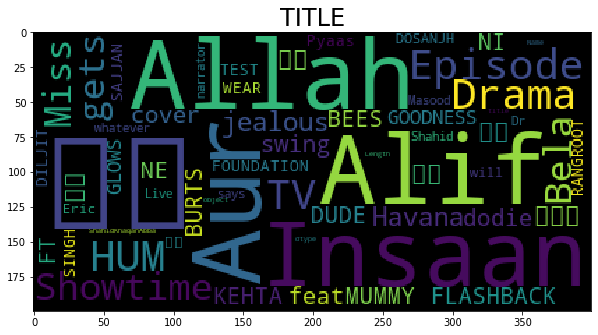

In [32]:
plotWord(Dataframe['title'],'title')

**ii) tag**

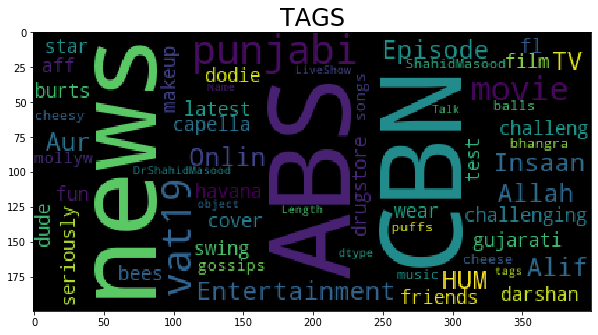

In [33]:
plotWord(Dataframe['tags'],'tags')

**iii) description**

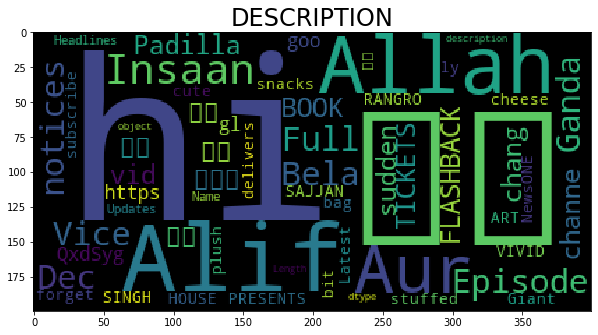

In [34]:
plotWord(Dataframe['description'],'description')

## Bivariate Analysis

We will analyse features two at a time in bivariate analysis.

1. **Numerical features**

Lets see how the vairables are related to each other by correlation heatmap

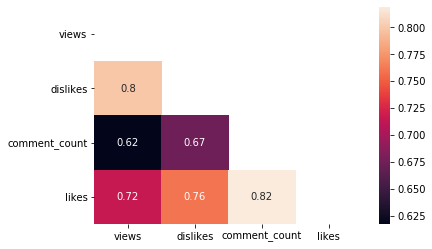

In [35]:
df = Dataframe[NUM_COL+[TARGET_COL]]
mask = np.triu(df.corr())
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True,mask=mask);

We can see that our target coulumn(likes) is positively correlated with all the numerical columns. We can answer some of our hypotheses from this information.

1. **Videos with more views get more likes**
> Yes. Videos with more views get more likes. 
2. **Videos with more comments get more likes**
> Yes. Videos with more comments get more likes
3. **Videos with less dislikes get more likes**
> Yes. Videos with less dislikes get more likes. When number of deslikes increase, number of views increase. Hence the number of likes also increase. 

We can look at the pairplot for futher clarification.

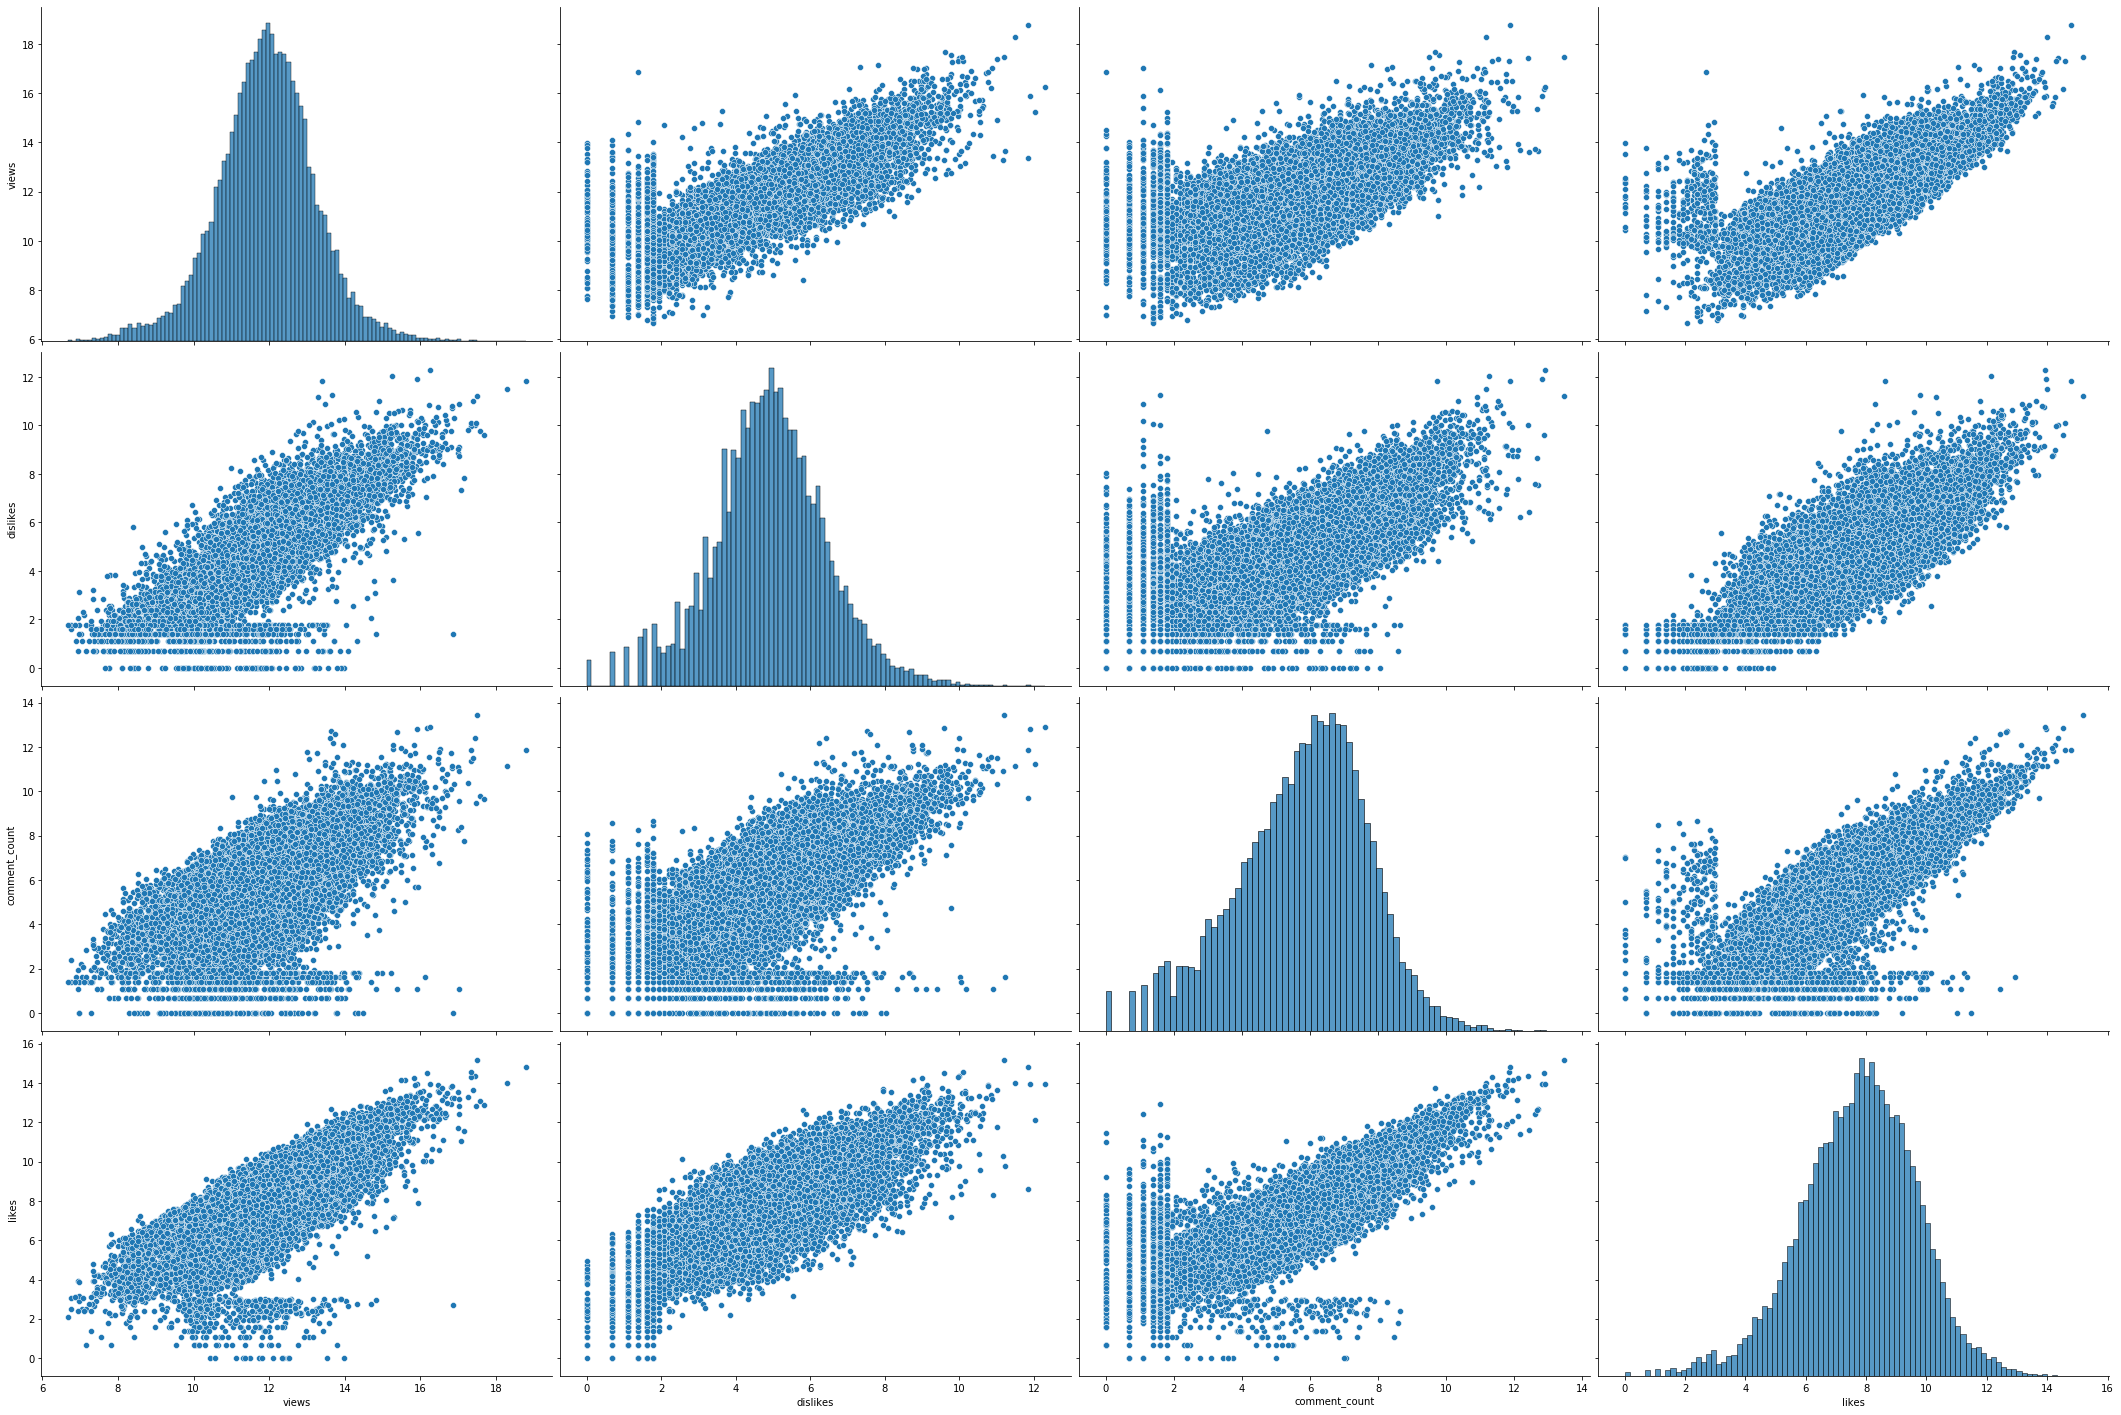

In [36]:
sns.pairplot(df, height=5, aspect=24/16);

2. **Categorical features**

In [37]:
CAT_COL

['channel_title', 'category_id', 'country_code']

**Countrywise number of videos**

In [38]:
countrywise_data = Dataframe.groupby(['country_code', 'channel_title']).size().reset_index()
countrywise_data.columns = ['country_code', 'channel_title', 'number_of_videos']
countrywise_data = countrywise_data.sort_values(by = 'number_of_videos', ascending = False)
countrywise_data.head(2)

,country_code,channel_title,number_of_videos
4937,IN,Study IQ education,118
5237,IN,etvteluguindia,115


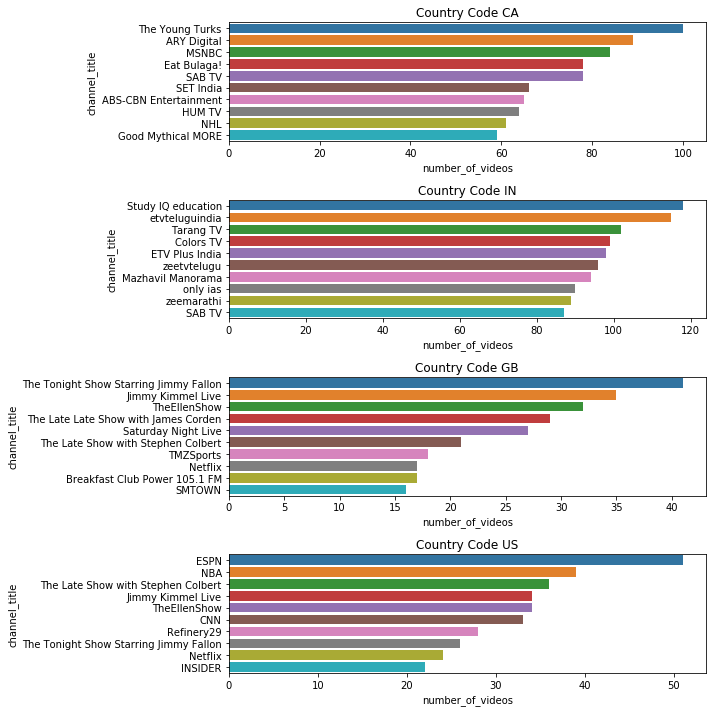

In [39]:
fig, axes = plt.subplots(4,1,figsize=(10,10))
for i, c in enumerate(Dataframe['country_code'].unique()):
    data = countrywise_data[countrywise_data['country_code'] == c][:10]
    sns.barplot(data=data,x='number_of_videos',y='channel_title',ax=axes[i])
    axes[i].set_title(f'Country Code {c}')
plt.tight_layout()

**Observation**
1. In Canada, top 3 channels are news and television programs
2. In India, top 3 channels are educaional and television/entertainment channels
3. In Britain, all the top 6 channels are talk shows.
4. In America, top 2 channels are sports channels and talk shows are in top 5.

**Mutivariate Analysis**

> We will analyse more than two variables at a time.

**Countrywise likes per channel**

In [40]:
countrywise_data2 = Dataframe.groupby(['country_code', 'channel_title'])['likes'].max().reset_index().sort_values(by = ['likes'], ascending=False)
countrywise_data2.head(2)

,country_code,channel_title,likes
3994,GB,ibighit,15.171369
3425,GB,LuisFonsiVEVO,14.803627


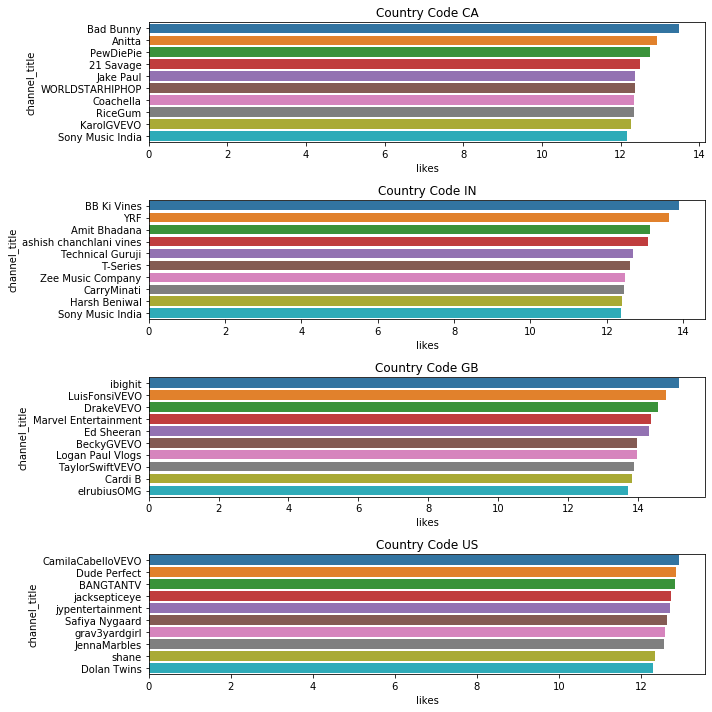

In [41]:
fig, axes = plt.subplots(4,1,figsize=(10,10))
for i, c in enumerate(Dataframe['country_code'].unique()):
    data = countrywise_data2[countrywise_data2['country_code'] == c][:10]
    sns.barplot(data=data,x='likes',y='channel_title',ax=axes[i])
    axes[i].set_title(f'Country Code {c}')
plt.tight_layout()

**Likes distribution for each category**

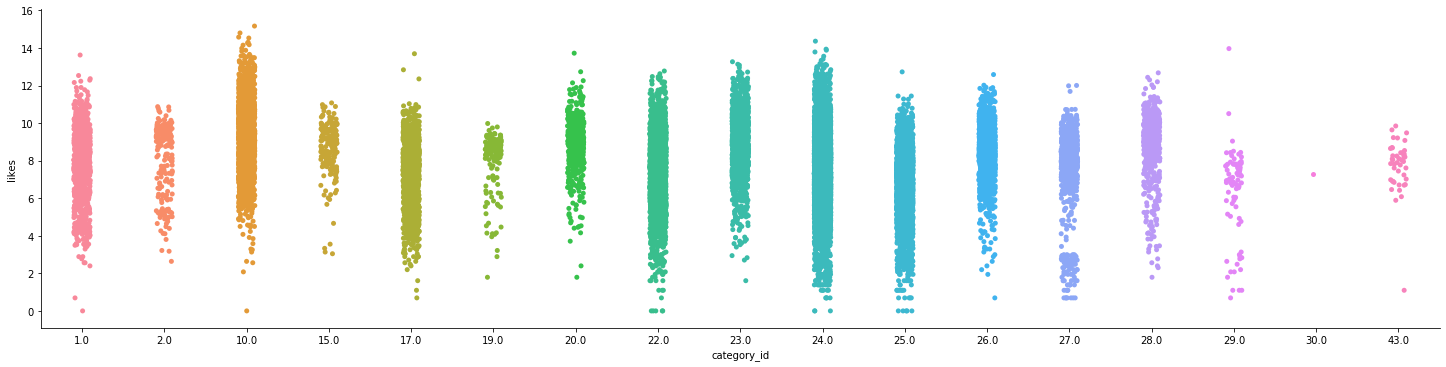

In [42]:
sns.catplot(data=Dataframe, x='category_id',y='likes', height=5, aspect=4);

**Likes distribution for each country**

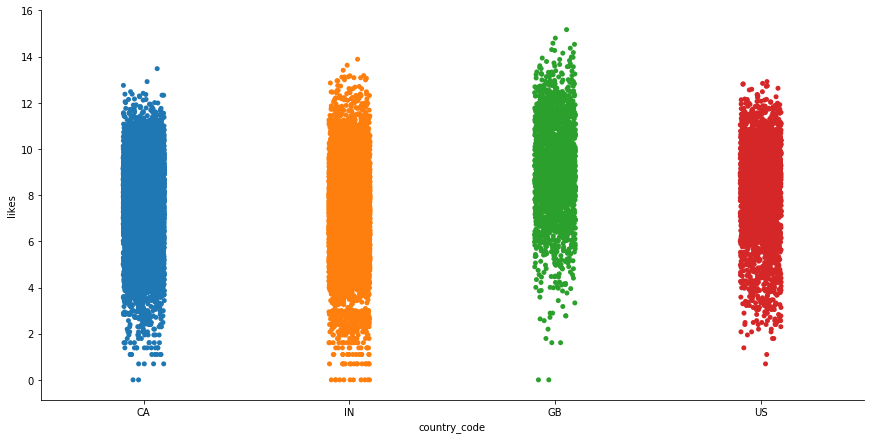

In [43]:
sns.catplot(data=Dataframe, x='country_code',y='likes', height=6, aspect=2);

**Mean likes per country**

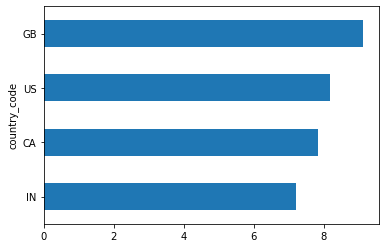

In [44]:
Dataframe.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh');

**Mean likes per channel**

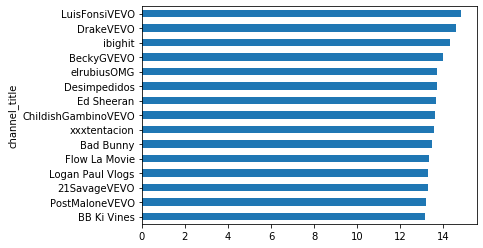

In [45]:
df1 = Dataframe.groupby('channel_title')['likes'].mean().sort_values(ascending = False)[:15]
df1[::-1].plot(kind = 'barh');

**Mean likes per category**

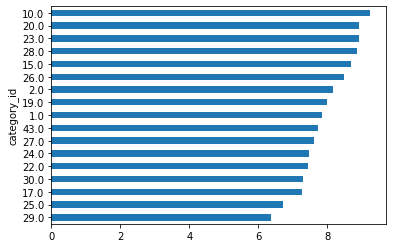

In [46]:
df1 = Dataframe.groupby('category_id')['likes'].mean().sort_values(ascending = False)
df1[::-1].plot(kind = 'barh');

We can answer some of our hypotheses from this information.
5. **Channel affects the number of likes**
> Yes.
6. **Category of the video affects the number of likes**
> Yes.
7. **The country of origin affects the number of likes**
> Yes. Videos from Britain seams to have higher average number of like while in the the least.

## Datetime variable

We have one datetime column: published date.

In [47]:
TIME_COL

'publish_date'

In [48]:
type(Dataframe['publish_date'][0])

str

We need to convert the publiched column to datetime format.

In [49]:
Dataframe['publish_date'] = pd.to_datetime(Dataframe['publish_date'])
Dataframe['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
26056   2018-01-16
26057   2017-12-17
26058   2018-03-04
26059   2018-05-17
26060   2018-01-16
Name: publish_date, Length: 26061, dtype: datetime64[ns]

In [50]:
type(Dataframe['publish_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Lets see how many videos we have in each year in the dataset

In [51]:
Dataframe['publish_date'].dt.year.value_counts()

2018    18841
2017     7132
2015       16
2016       16
2011       13
2014        9
2013        9
2009        8
2012        6
2010        4
2008        3
2007        3
2006        1
Name: publish_date, dtype: int64

**Almost every videos are from the year 2018 and 2017**

Lets consider the videos which are published in 2017 and 2018

In [52]:
new_data = Dataframe.query('publish_date >= 2017')

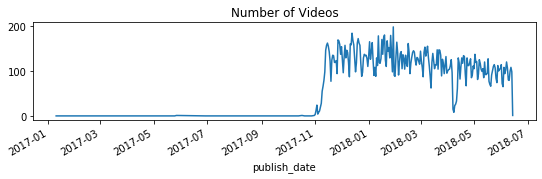

In [53]:
new_data.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(9, 2),title = 'Number of Videos');

We can see that, there are no videos before NOVEMBER 2017. So we will analyse the videos published after NOVEMBER 2017

In [54]:
new_data = Dataframe.query('publish_date > "2017-11"')

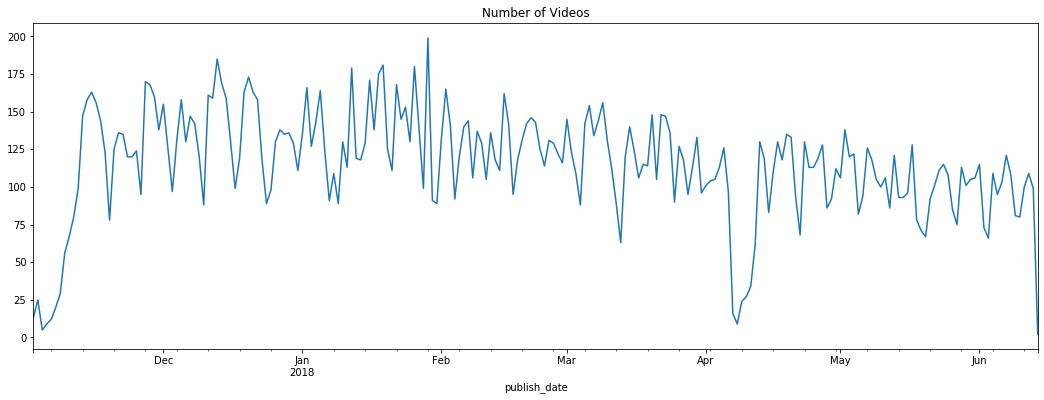

In [55]:
new_data.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6),title = 'Number of Videos');

There is a very sharp dip in the number of videos in the beginning of April of 2018.

**Mean Likes in Data during different months**

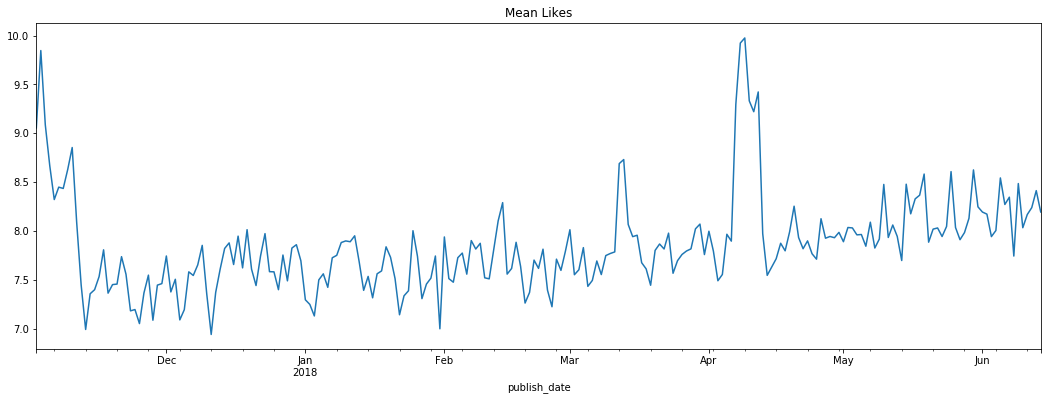

In [56]:
new_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes");

There is a very sharp increase in mean likes in the beginning of April of 2018. This is because of the sharp dip in the number of videos during this time period. 

**Now we check this countrywise**

1. Number of videos by country

In [57]:
temp = new_data.groupby(['publish_date', 'country_code']).size().reset_index()
temp.pivot_table(index = 'publish_date', columns = 'country_code', values=0)

country_code,CA,GB,IN,US
publish_date,,,,
2017-11-02,1.0,11.0,NaN,1.0
2017-11-03,1.0,24.0,NaN,NaN
2017-11-04,NaN,5.0,NaN,NaN
2017-11-05,NaN,9.0,NaN,NaN
2017-11-06,NaN,11.0,NaN,1.0
...,...,...,...,...
2018-06-10,42.0,2.0,31.0,5.0
2018-06-11,46.0,4.0,45.0,5.0
2018-06-12,64.0,5.0,37.0,3.0


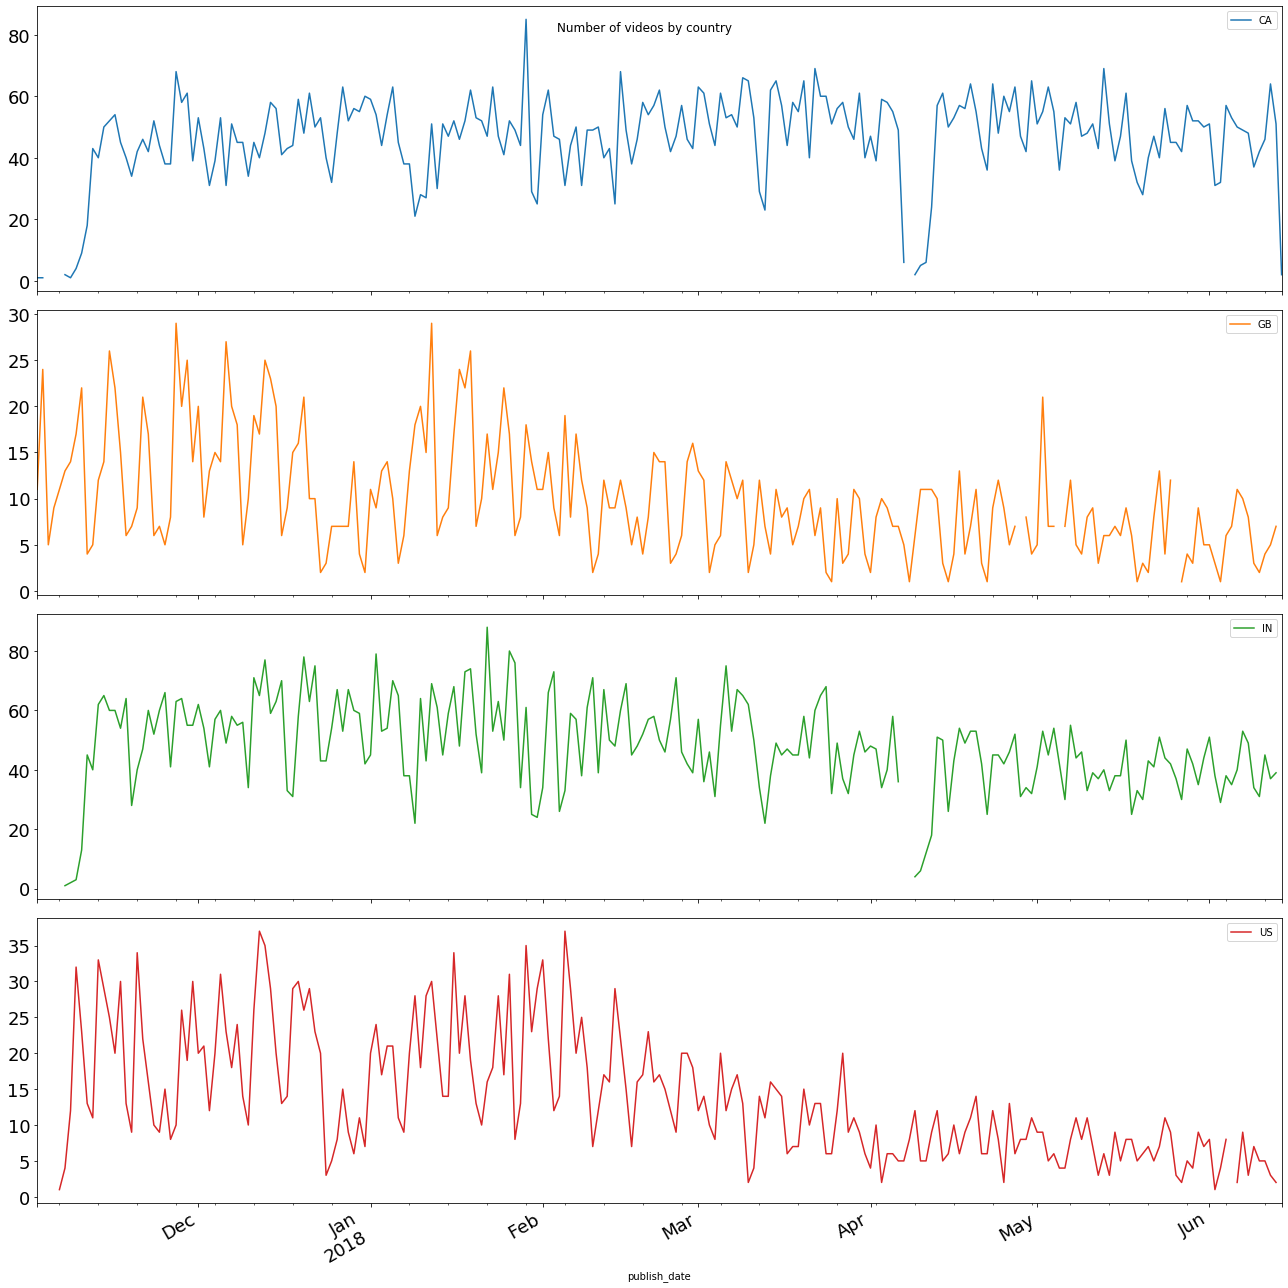

In [58]:
temp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, title='Number of videos by country',figsize=(18, 18),fontsize=18)
plt.tight_layout()

2. Mean likes by country

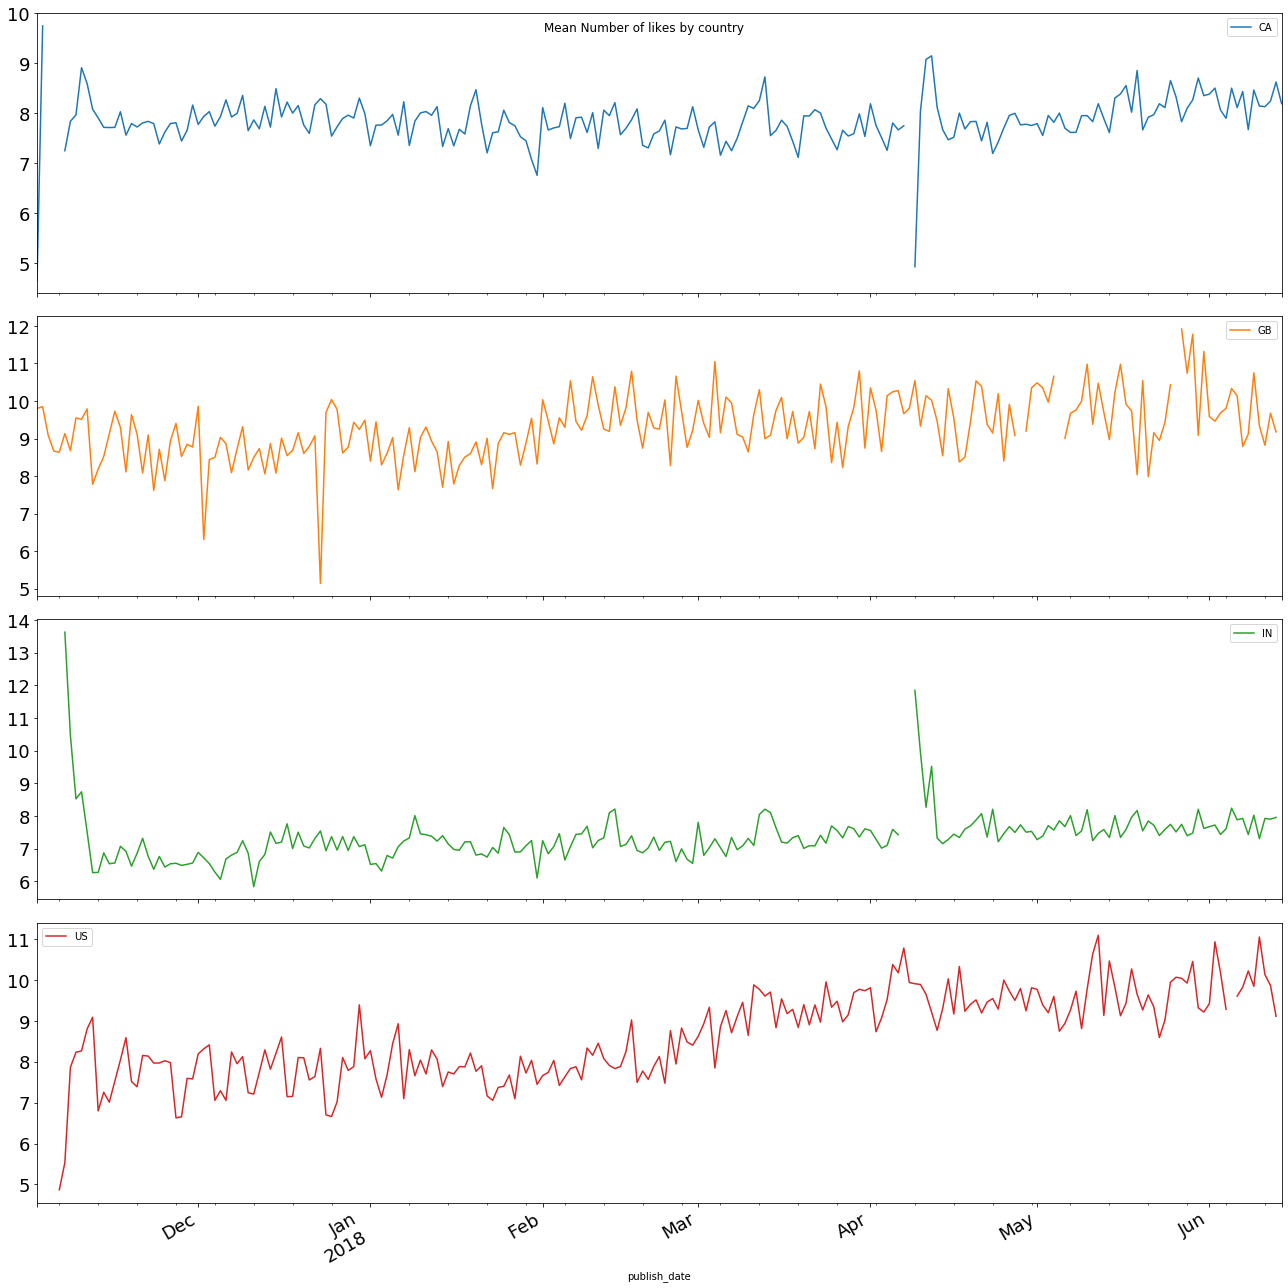

In [59]:
temp = new_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
temp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, title='Mean Number of likes by country',figsize=(18, 18),fontsize=18)
plt.tight_layout()

We can check the number of videos publishing in each day of the week. This will help us to answer the hypotheses: 
8. **People post more videos on weekends than weekdays**

We will add one column to our dataset which contain the day of the week for this analysis.

In [60]:
plt.style.use('ggplot')

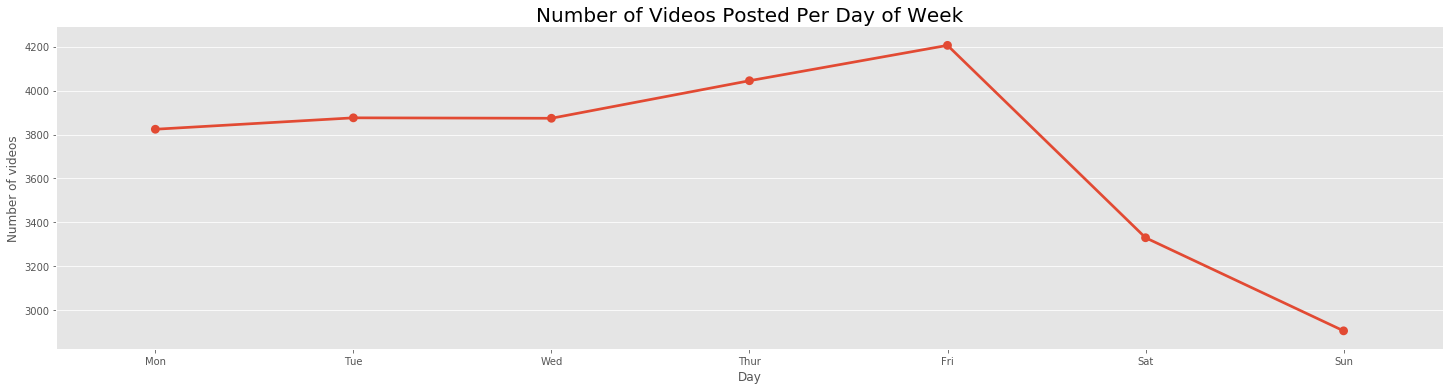

In [61]:
Dataframe['day'] = Dataframe['publish_date'].dt.dayofweek
temp = Dataframe['day'].value_counts().sort_index().reset_index()
temp.columns = ['Day','Number of videos']
temp.Day = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
sns.catplot(data=temp,x='Day',y='Number of videos',aspect = 4,kind='point')
plt.title("Number of Videos Posted Per Day of Week", fontsize=20);

We can see that most number of videos are uploaded on fridays. And our hypothesis is proven wrong. In weakends, number of videos being uploaded is the least.

We have one more hypothesis left to answer:

4. **Descriptive videos get more number of likes**

We can use correlation heatmap for answering this.

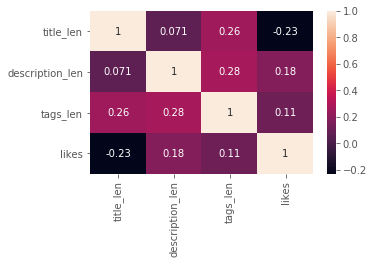

In [62]:
Dataframe['title_len'] =Dataframe['title'].apply(lambda x:len(x))
Dataframe['description_len'] =Dataframe['description'].apply(lambda x:len(x))
Dataframe['tags_len'] =Dataframe['tags'].apply(lambda x:len(x))
plt.subplots(figsize=(5,3))
sns.heatmap(Dataframe[['title_len', 'description_len', 'tags_len', 'likes']].corr(), annot = True);


From the heatmap we can see that:
1. title length is negatively correlated to likes and
2. description and tag lengths have a positive correlation

So if you keep your title length short and description long, you are having higher chances of getting more likes.

## Modelling

In [63]:
Dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   video_id         26061 non-null  int64         
 1   title            26061 non-null  object        
 2   channel_title    26061 non-null  object        
 3   category_id      26061 non-null  float64       
 4   publish_date     26061 non-null  datetime64[ns]
 5   tags             26061 non-null  object        
 6   views            26061 non-null  float64       
 7   dislikes         26061 non-null  float64       
 8   comment_count    26061 non-null  float64       
 9   description      26061 non-null  object        
 10  country_code     26061 non-null  object        
 11  likes            26061 non-null  float64       
 12  day              26061 non-null  int64         
 13  title_len        26061 non-null  int64         
 14  description_len  26061 non-null  int64

In [64]:
Dataframe.isnull().sum()

video_id           0
title              0
channel_title      0
category_id        0
publish_date       0
tags               0
views              0
dislikes           0
comment_count      0
description        0
country_code       0
likes              0
day                0
title_len          0
description_len    0
tags_len           0
dtype: int64

In [65]:
NUM_COL = ['views', 'dislikes', 'comment_count']
CAT_COL = ['category_id', 'country_code']
TEXT_COL = ['title', 'channel_title', 'tags', 'description']
TIME_COL = ['publish_date']

**country_code column is in string format. We can encode it so that we can use it for modelling**

In [66]:
Dataframe = pd.get_dummies(Dataframe, columns = CAT_COL)
Dataframe.head(2)

,video_id,title,channel_title,publish_date,tags,views,dislikes,comment_count,description,likes,day,title_len,description_len,tags_len,category_id_1.0,category_id_2.0,category_id_10.0,category_id_15.0,category_id_17.0,category_id_19.0,category_id_20.0,category_id_22.0,category_id_23.0,category_id_24.0,category_id_25.0,category_id_26.0,category_id_27.0,category_id_28.0,category_id_29.0,category_id_30.0,category_id_43.0,country_code_CA,country_code_GB,country_code_IN,country_code_US
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",12.769769,5.700444,6.803505,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,7.763021,1,64,1030,187,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",13.042257,4.317488,5.752573,Vice Ganda notices Bela Padilla's sudden chang...,8.091015,3,55,599,494,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


### Split the dataset into training and validation sets.

We will use 80-20 split with 80% of the rows belonging to training data.

In [67]:
trn, val = train_test_split(Dataframe, test_size=0.2, random_state=63)
Dataframe.shape[0],trn.shape[0], val.shape[0]

(26061, 20848, 5213)

In [68]:
features = [c for c in Dataframe.columns if c not in [ID_COL]+[TARGET_COL]]
CAT_NUM_COL = [c for c in features if c not in TEXT_COL+TIME_COL]
CAT_NUM_COL

['views',
 'dislikes',
 'comment_count',
 'day',
 'title_len',
 'description_len',
 'tags_len',
 'category_id_1.0',
 'category_id_2.0',
 'category_id_10.0',
 'category_id_15.0',
 'category_id_17.0',
 'category_id_19.0',
 'category_id_20.0',
 'category_id_22.0',
 'category_id_23.0',
 'category_id_24.0',
 'category_id_25.0',
 'category_id_26.0',
 'category_id_27.0',
 'category_id_28.0',
 'category_id_29.0',
 'category_id_30.0',
 'category_id_43.0',
 'country_code_CA',
 'country_code_GB',
 'country_code_IN',
 'country_code_US']

In [69]:
X_trn, X_val, y_trn, y_val = trn[features], val[features], trn[TARGET_COL], val[TARGET_COL]
# X_trn and y_trn are the dataset we will use to train our model
# We will predict the target column using X_val and check the result with the output with the actual value y_val

### Linear Regression
#### 1. Training using Numerical features

In [70]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_trn[NUM_COL],y_trn)
pred = Lin_reg.predict(X_val[NUM_COL])

**Let us take a look at our prediction and actual values**

In [71]:
comprsn = pd.DataFrame(data={'predictions': pred, 'actual': y_val})
comprsn

,predictions,actual
12061,9.129610,6.655440
6599,4.274881,5.342334
1836,5.689831,4.779123
4208,8.847895,7.823646
20407,8.814543,9.152605
...,...,...
17036,9.092941,9.420115
18025,6.353081,5.880533
24670,8.745252,9.310548
12125,7.031010,7.944847


In [72]:
#for i in comprsn.columns:
#    comprsn[i] = comprsn[i].apply(lambda x:np.expm1(x))
#comprsn

In [73]:
#plt.scatter(x=list(range(5213)), y=comprsn['predictions'],label='Predicted')
#plt.scatter(x=list(range(5213)), y=comprsn['actual'],color='red',label='Actual')
#plt.legend()
#plt.show()

**We need to evaluate the performance of our model. We can use various evaluation metrices such as:**

1. Mean Squared Error(MSE)
2. Root-Mean-Squared-Error(RMSE)
3. Root Mean Squared Log Error(RMSLE)
4. Mean-Absolute-Error(MAE).
5. R²
6. Adjusted R²

**We can use R² and RMSE for the evaluation. Values for R² ranges from 0 to 1. Closer the R² value to 1, bettr our model performs.**

In [74]:
# Evaluation Metrices
def score(y_val,pred):
    print('RMSE\t: ', np.sqrt(mean_squared_error(y_val,pred)))
    print('R²\t: ',r2_score(y_val,pred))

In [75]:
score(y_val,pred)

RMSE	:  0.9256090513508034
R²	:  0.7692359553327757


#### 2. Training using Numerical and Categorical features

In [76]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_trn[CAT_NUM_COL],y_trn)
pred = Lin_reg.predict(X_val[CAT_NUM_COL])

In [77]:
score(y_val,pred)

RMSE	:  0.8435677496099154
R²	:  0.8083305518428854


**We can see that our results are improved. Root Mean Square Error is reduced and the R² score is increased to 80%.**

### Decition Tree Model

In [78]:
DT = DecisionTreeRegressor(random_state=63)
DT.fit(X_trn[CAT_NUM_COL],y_trn)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=63, splitter='best')

In [79]:
pred = DT.predict(X_val[CAT_NUM_COL])

In [80]:
score(y_val,pred)

RMSE	:  0.8976916981861263
R²	:  0.7829462095545799


There is no improvement after using Decision tree. So we have to specify some of the hyperparameters to get a good result.

In [81]:
DT = DecisionTreeRegressor(random_state=63, max_depth=12,min_samples_split=30, min_samples_leaf= 10, max_leaf_nodes=396)
DT.fit(X_trn[CAT_NUM_COL],y_trn)
pred = DT.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

RMSE	:  0.7341625868794904
R²	:  0.8548231213805365


**Grid Search**

In [82]:
#hyperparam_combs = {
#    'max_depth': [ 8, 10, 12, 14, 16],
#    'min_samples_split': [20, 30, 40],
#    'max_features': [0.6, 0.8, 1],
#    'max_leaf_nodes': [253, 396, 128],
#}

#clf = GridSearchCV(DecisionTreeRegressor(),
#                         hyperparam_combs,
#                         scoring='r2')

#search = clf.fit(X_trn[CAT_NUM_COL],y_trn)

#search.best_params_

In [83]:
best_parm = {'max_depth': 16,
 'max_features': 0.8,
 'max_leaf_nodes': 396,
 'min_samples_split': 30}
DT = DecisionTreeRegressor(random_state=63,**best_parm)
DT.fit(X_trn[CAT_NUM_COL],y_trn)
pred = DT.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

RMSE	:  0.7395403850806784
R²	:  0.8526884677440504


**Gradient Boosting**
1. LightGBM

In [84]:
LGB = LGBMRegressor(random_state=63)
LGB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = LGB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

RMSE	:  0.6295551271587297
R²	:  0.8932469020261351


In [85]:
#hyperparam_combs = {
#    'num_leaves': [31, 127],
#    'reg_alpha': [0.1, 0.5],
#    'min_data_in_leaf': [30, 50, 100, 300, 400],
#    'lambda_l1': [0, 1, 1.5],
#    'lambda_l2': [0, 1]
#    }
#
#clf = GridSearchCV(LGBMRegressor(),
#                         hyperparam_combs,
#                         scoring='r2')
#
#search = clf.fit(X_trn[CAT_NUM_COL],y_trn)
#
#search.best_params_

In [86]:
best_parm = {'lambda_l1': 0,
 'lambda_l2': 1,
 'min_data_in_leaf': 30,
 'num_leaves': 127,
 'reg_alpha': 0.1}
LGB = LGBMRegressor(random_state=63,**best_parm)
LGB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = LGB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
RMSE	:  0.6028646663902235
R²	:  0.9021067790262407


In [87]:
comprsn = pd.DataFrame(data={'predictions': pred, 'actual': y_val})
comprsn

,predictions,actual
12061,7.337127,6.655440
6599,4.591361,5.342334
1836,4.932083,4.779123
4208,8.000117,7.823646
20407,8.747728,9.152605
...,...,...
17036,9.585739,9.420115
18025,5.720946,5.880533
24670,8.688409,9.310548
12125,7.824834,7.944847


In [88]:
x=LGB.feature_name_
y=LGB.feature_importances_

In [89]:
pd.DataFrame({'x':y,'y':x}).sort_values(by = 'x',ascending=False).set_index('y')

,x
y,
description_len,2039
tags_len,1734
views,1690
dislikes,1652
comment_count,1564
title_len,1494
day,402
category_id_24.0,263
country_code_CA,262


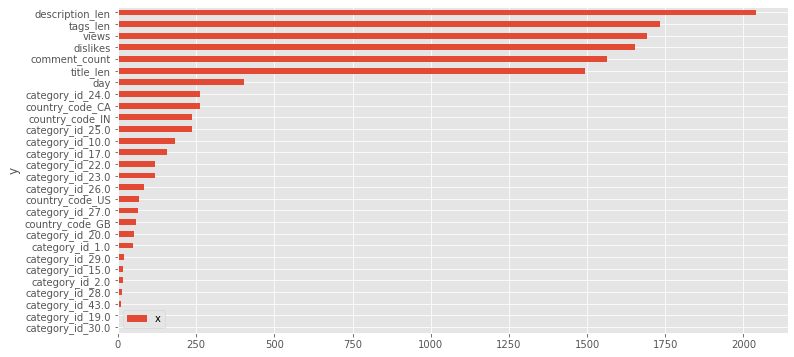

In [90]:
pd.DataFrame({'x':y,'y':x}).sort_values(by = 'x',ascending=False).set_index('y')[::-1].plot(kind='barh',figsize=(12, 6));

RMSE	:  0.5959047429872405
R²	:  0.9043540377169839


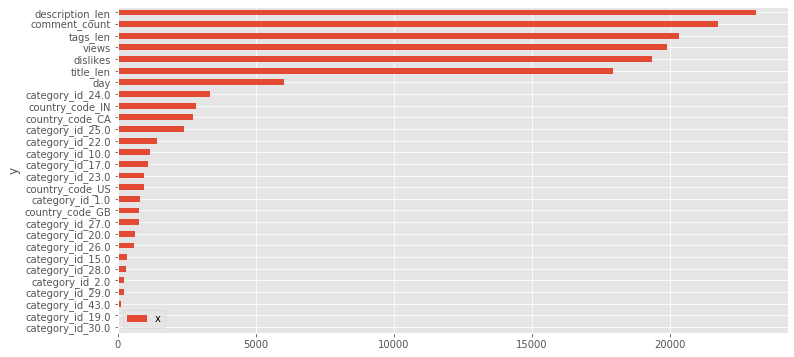

In [91]:
LGB = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
LGB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = LGB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)
x=LGB.feature_name_
y=LGB.feature_importances_
pd.DataFrame({'x':y,'y':x}).sort_values(by = 'x',ascending=False).set_index('y')[::-1].plot(kind='barh',figsize=(12, 6));

0:	learn: 1.9148707	total: 82.6ms	remaining: 4m 7s
1:	learn: 1.9020447	total: 88.3ms	remaining: 2m 12s
2:	learn: 1.8880901	total: 94.5ms	remaining: 1m 34s
3:	learn: 1.8744430	total: 102ms	remaining: 1m 16s
4:	learn: 1.8613186	total: 107ms	remaining: 1m 4s
5:	learn: 1.8490073	total: 114ms	remaining: 56.9s
6:	learn: 1.8359478	total: 119ms	remaining: 50.9s
7:	learn: 1.8235258	total: 125ms	remaining: 46.8s
8:	learn: 1.8105525	total: 131ms	remaining: 43.5s
9:	learn: 1.7978627	total: 146ms	remaining: 43.7s
10:	learn: 1.7861177	total: 153ms	remaining: 41.5s
11:	learn: 1.7735966	total: 159ms	remaining: 39.5s
12:	learn: 1.7628993	total: 165ms	remaining: 37.9s
13:	learn: 1.7512042	total: 171ms	remaining: 36.4s
14:	learn: 1.7386890	total: 177ms	remaining: 35.1s
15:	learn: 1.7267749	total: 182ms	remaining: 33.9s
16:	learn: 1.7155220	total: 188ms	remaining: 33.1s
17:	learn: 1.7041148	total: 194ms	remaining: 32.2s
18:	learn: 1.6939803	total: 198ms	remaining: 31.1s
19:	learn: 1.6830836	total: 202ms	r

174:	learn: 0.8807649	total: 866ms	remaining: 14s
175:	learn: 0.8791622	total: 872ms	remaining: 14s
176:	learn: 0.8774638	total: 874ms	remaining: 13.9s
177:	learn: 0.8756883	total: 877ms	remaining: 13.9s
178:	learn: 0.8739151	total: 880ms	remaining: 13.9s
179:	learn: 0.8721828	total: 883ms	remaining: 13.8s
180:	learn: 0.8704704	total: 888ms	remaining: 13.8s
181:	learn: 0.8689805	total: 894ms	remaining: 13.8s
182:	learn: 0.8673832	total: 902ms	remaining: 13.9s
183:	learn: 0.8657077	total: 905ms	remaining: 13.8s
184:	learn: 0.8639731	total: 908ms	remaining: 13.8s
185:	learn: 0.8624691	total: 910ms	remaining: 13.8s
186:	learn: 0.8608050	total: 913ms	remaining: 13.7s
187:	learn: 0.8594016	total: 919ms	remaining: 13.7s
188:	learn: 0.8577621	total: 924ms	remaining: 13.7s
189:	learn: 0.8561541	total: 927ms	remaining: 13.7s
190:	learn: 0.8546617	total: 929ms	remaining: 13.7s
191:	learn: 0.8531927	total: 935ms	remaining: 13.7s
192:	learn: 0.8517078	total: 938ms	remaining: 13.6s
193:	learn: 0.85

341:	learn: 0.7430247	total: 1.66s	remaining: 12.9s
342:	learn: 0.7425931	total: 1.66s	remaining: 12.9s
343:	learn: 0.7423201	total: 1.67s	remaining: 12.9s
344:	learn: 0.7420287	total: 1.68s	remaining: 12.9s
345:	learn: 0.7417060	total: 1.69s	remaining: 12.9s
346:	learn: 0.7413676	total: 1.7s	remaining: 13s
347:	learn: 0.7410758	total: 1.71s	remaining: 13s
348:	learn: 0.7407420	total: 1.71s	remaining: 13s
349:	learn: 0.7403574	total: 1.72s	remaining: 13s
350:	learn: 0.7399936	total: 1.72s	remaining: 13s
351:	learn: 0.7396502	total: 1.72s	remaining: 13s
352:	learn: 0.7393497	total: 1.73s	remaining: 13s
353:	learn: 0.7390001	total: 1.73s	remaining: 12.9s
354:	learn: 0.7386716	total: 1.73s	remaining: 12.9s
355:	learn: 0.7383690	total: 1.74s	remaining: 12.9s
356:	learn: 0.7380995	total: 1.74s	remaining: 12.9s
357:	learn: 0.7378175	total: 1.74s	remaining: 12.9s
358:	learn: 0.7374849	total: 1.75s	remaining: 12.9s
359:	learn: 0.7371642	total: 1.75s	remaining: 12.9s
360:	learn: 0.7369066	total

536:	learn: 0.7042215	total: 2.48s	remaining: 11.4s
537:	learn: 0.7040476	total: 2.48s	remaining: 11.4s
538:	learn: 0.7039181	total: 2.48s	remaining: 11.3s
539:	learn: 0.7037653	total: 2.49s	remaining: 11.3s
540:	learn: 0.7036272	total: 2.49s	remaining: 11.3s
541:	learn: 0.7035399	total: 2.5s	remaining: 11.3s
542:	learn: 0.7034527	total: 2.51s	remaining: 11.3s
543:	learn: 0.7032587	total: 2.51s	remaining: 11.4s
544:	learn: 0.7031565	total: 2.52s	remaining: 11.3s
545:	learn: 0.7030130	total: 2.52s	remaining: 11.3s
546:	learn: 0.7029176	total: 2.53s	remaining: 11.3s
547:	learn: 0.7028102	total: 2.53s	remaining: 11.3s
548:	learn: 0.7026510	total: 2.53s	remaining: 11.3s
549:	learn: 0.7025190	total: 2.54s	remaining: 11.3s
550:	learn: 0.7024337	total: 2.54s	remaining: 11.3s
551:	learn: 0.7023440	total: 2.54s	remaining: 11.3s
552:	learn: 0.7021962	total: 2.55s	remaining: 11.3s
553:	learn: 0.7020775	total: 2.55s	remaining: 11.3s
554:	learn: 0.7019170	total: 2.56s	remaining: 11.3s
555:	learn: 0

725:	learn: 0.6856731	total: 3.27s	remaining: 10.3s
726:	learn: 0.6856226	total: 3.28s	remaining: 10.3s
727:	learn: 0.6855310	total: 3.29s	remaining: 10.3s
728:	learn: 0.6854634	total: 3.3s	remaining: 10.3s
729:	learn: 0.6854209	total: 3.31s	remaining: 10.3s
730:	learn: 0.6853368	total: 3.32s	remaining: 10.3s
731:	learn: 0.6852709	total: 3.32s	remaining: 10.3s
732:	learn: 0.6852206	total: 3.33s	remaining: 10.3s
733:	learn: 0.6851268	total: 3.33s	remaining: 10.3s
734:	learn: 0.6850583	total: 3.33s	remaining: 10.3s
735:	learn: 0.6849166	total: 3.33s	remaining: 10.3s
736:	learn: 0.6847979	total: 3.34s	remaining: 10.2s
737:	learn: 0.6847057	total: 3.34s	remaining: 10.2s
738:	learn: 0.6846060	total: 3.35s	remaining: 10.2s
739:	learn: 0.6845426	total: 3.35s	remaining: 10.2s
740:	learn: 0.6844558	total: 3.35s	remaining: 10.2s
741:	learn: 0.6844017	total: 3.36s	remaining: 10.2s
742:	learn: 0.6843168	total: 3.36s	remaining: 10.2s
743:	learn: 0.6842661	total: 3.37s	remaining: 10.2s
744:	learn: 0

915:	learn: 0.6708955	total: 4.29s	remaining: 9.76s
916:	learn: 0.6707830	total: 4.3s	remaining: 9.76s
917:	learn: 0.6707273	total: 4.3s	remaining: 9.76s
918:	learn: 0.6706794	total: 4.31s	remaining: 9.75s
919:	learn: 0.6706078	total: 4.32s	remaining: 9.76s
920:	learn: 0.6705590	total: 4.32s	remaining: 9.75s
921:	learn: 0.6704699	total: 4.32s	remaining: 9.75s
922:	learn: 0.6704292	total: 4.33s	remaining: 9.74s
923:	learn: 0.6703819	total: 4.33s	remaining: 9.73s
924:	learn: 0.6703292	total: 4.33s	remaining: 9.72s
925:	learn: 0.6702224	total: 4.34s	remaining: 9.72s
926:	learn: 0.6701617	total: 4.34s	remaining: 9.72s
927:	learn: 0.6700258	total: 4.35s	remaining: 9.71s
928:	learn: 0.6699736	total: 4.35s	remaining: 9.7s
929:	learn: 0.6699279	total: 4.35s	remaining: 9.69s
930:	learn: 0.6698905	total: 4.36s	remaining: 9.68s
931:	learn: 0.6698379	total: 4.36s	remaining: 9.67s
932:	learn: 0.6697865	total: 4.36s	remaining: 9.66s
933:	learn: 0.6696765	total: 4.36s	remaining: 9.65s
934:	learn: 0.6

1093:	learn: 0.6588788	total: 4.88s	remaining: 8.51s
1094:	learn: 0.6588366	total: 4.89s	remaining: 8.51s
1095:	learn: 0.6587678	total: 4.9s	remaining: 8.51s
1096:	learn: 0.6586905	total: 4.91s	remaining: 8.52s
1097:	learn: 0.6585869	total: 4.91s	remaining: 8.51s
1098:	learn: 0.6585347	total: 4.92s	remaining: 8.5s
1099:	learn: 0.6584577	total: 4.92s	remaining: 8.49s
1100:	learn: 0.6583982	total: 4.92s	remaining: 8.49s
1101:	learn: 0.6583623	total: 4.92s	remaining: 8.48s
1102:	learn: 0.6583246	total: 4.93s	remaining: 8.47s
1103:	learn: 0.6582576	total: 4.93s	remaining: 8.47s
1104:	learn: 0.6582078	total: 4.93s	remaining: 8.46s
1105:	learn: 0.6581563	total: 4.93s	remaining: 8.45s
1106:	learn: 0.6580740	total: 4.94s	remaining: 8.44s
1107:	learn: 0.6580460	total: 4.94s	remaining: 8.44s
1108:	learn: 0.6579666	total: 4.94s	remaining: 8.43s
1109:	learn: 0.6578859	total: 4.95s	remaining: 8.42s
1110:	learn: 0.6578379	total: 4.95s	remaining: 8.41s
1111:	learn: 0.6577697	total: 4.95s	remaining: 8

1253:	learn: 0.6492073	total: 5.48s	remaining: 7.63s
1254:	learn: 0.6491382	total: 5.49s	remaining: 7.63s
1255:	learn: 0.6490651	total: 5.5s	remaining: 7.64s
1256:	learn: 0.6490140	total: 5.51s	remaining: 7.64s
1257:	learn: 0.6489461	total: 5.51s	remaining: 7.64s
1258:	learn: 0.6488901	total: 5.52s	remaining: 7.64s
1259:	learn: 0.6488086	total: 5.53s	remaining: 7.64s
1260:	learn: 0.6487428	total: 5.54s	remaining: 7.64s
1261:	learn: 0.6487018	total: 5.55s	remaining: 7.64s
1262:	learn: 0.6486318	total: 5.56s	remaining: 7.64s
1263:	learn: 0.6486002	total: 5.57s	remaining: 7.64s
1264:	learn: 0.6485443	total: 5.57s	remaining: 7.64s
1265:	learn: 0.6484718	total: 5.58s	remaining: 7.64s
1266:	learn: 0.6484185	total: 5.59s	remaining: 7.64s
1267:	learn: 0.6483199	total: 5.59s	remaining: 7.64s
1268:	learn: 0.6482659	total: 5.6s	remaining: 7.64s
1269:	learn: 0.6481830	total: 5.6s	remaining: 7.63s
1270:	learn: 0.6481163	total: 5.61s	remaining: 7.63s
1271:	learn: 0.6480546	total: 5.61s	remaining: 7.

1416:	learn: 0.6398236	total: 6.08s	remaining: 6.79s
1417:	learn: 0.6397805	total: 6.09s	remaining: 6.79s
1418:	learn: 0.6397173	total: 6.09s	remaining: 6.79s
1419:	learn: 0.6396929	total: 6.1s	remaining: 6.79s
1420:	learn: 0.6396506	total: 6.1s	remaining: 6.78s
1421:	learn: 0.6396072	total: 6.11s	remaining: 6.78s
1422:	learn: 0.6395650	total: 6.11s	remaining: 6.77s
1423:	learn: 0.6395295	total: 6.11s	remaining: 6.77s
1424:	learn: 0.6394875	total: 6.13s	remaining: 6.77s
1425:	learn: 0.6394420	total: 6.13s	remaining: 6.77s
1426:	learn: 0.6393512	total: 6.14s	remaining: 6.77s
1427:	learn: 0.6392801	total: 6.15s	remaining: 6.77s
1428:	learn: 0.6392336	total: 6.15s	remaining: 6.77s
1429:	learn: 0.6391925	total: 6.16s	remaining: 6.76s
1430:	learn: 0.6391470	total: 6.17s	remaining: 6.76s
1431:	learn: 0.6390670	total: 6.18s	remaining: 6.76s
1432:	learn: 0.6390149	total: 6.19s	remaining: 6.76s
1433:	learn: 0.6389601	total: 6.2s	remaining: 6.76s
1434:	learn: 0.6389044	total: 6.2s	remaining: 6.7

1625:	learn: 0.6296303	total: 6.87s	remaining: 5.81s
1626:	learn: 0.6295917	total: 6.88s	remaining: 5.81s
1627:	learn: 0.6295354	total: 6.89s	remaining: 5.8s
1628:	learn: 0.6294857	total: 6.89s	remaining: 5.8s
1629:	learn: 0.6294349	total: 6.9s	remaining: 5.8s
1630:	learn: 0.6293924	total: 6.9s	remaining: 5.79s
1631:	learn: 0.6293613	total: 6.9s	remaining: 5.79s
1632:	learn: 0.6293035	total: 6.91s	remaining: 5.78s
1633:	learn: 0.6292525	total: 6.91s	remaining: 5.78s
1634:	learn: 0.6292175	total: 6.91s	remaining: 5.77s
1635:	learn: 0.6291638	total: 6.92s	remaining: 5.76s
1636:	learn: 0.6291055	total: 6.92s	remaining: 5.76s
1637:	learn: 0.6290558	total: 6.92s	remaining: 5.75s
1638:	learn: 0.6290016	total: 6.92s	remaining: 5.75s
1639:	learn: 0.6289606	total: 6.93s	remaining: 5.74s
1640:	learn: 0.6289174	total: 6.93s	remaining: 5.74s
1641:	learn: 0.6288616	total: 6.93s	remaining: 5.73s
1642:	learn: 0.6288059	total: 6.93s	remaining: 5.73s
1643:	learn: 0.6287435	total: 6.94s	remaining: 5.72s

1804:	learn: 0.6216509	total: 7.67s	remaining: 5.08s
1805:	learn: 0.6216159	total: 7.67s	remaining: 5.07s
1806:	learn: 0.6215865	total: 7.68s	remaining: 5.07s
1807:	learn: 0.6215452	total: 7.68s	remaining: 5.06s
1808:	learn: 0.6215099	total: 7.68s	remaining: 5.06s
1809:	learn: 0.6214435	total: 7.69s	remaining: 5.06s
1810:	learn: 0.6214094	total: 7.7s	remaining: 5.05s
1811:	learn: 0.6213534	total: 7.71s	remaining: 5.05s
1812:	learn: 0.6213302	total: 7.71s	remaining: 5.05s
1813:	learn: 0.6212948	total: 7.71s	remaining: 5.04s
1814:	learn: 0.6212433	total: 7.72s	remaining: 5.04s
1815:	learn: 0.6211905	total: 7.72s	remaining: 5.04s
1816:	learn: 0.6211544	total: 7.73s	remaining: 5.03s
1817:	learn: 0.6211192	total: 7.73s	remaining: 5.03s
1818:	learn: 0.6210694	total: 7.74s	remaining: 5.02s
1819:	learn: 0.6210479	total: 7.74s	remaining: 5.02s
1820:	learn: 0.6210059	total: 7.74s	remaining: 5.01s
1821:	learn: 0.6209701	total: 7.75s	remaining: 5.01s
1822:	learn: 0.6209235	total: 7.75s	remaining: 

1999:	learn: 0.6139512	total: 8.89s	remaining: 4.45s
2000:	learn: 0.6139278	total: 8.9s	remaining: 4.44s
2001:	learn: 0.6138713	total: 8.91s	remaining: 4.44s
2002:	learn: 0.6138407	total: 8.92s	remaining: 4.44s
2003:	learn: 0.6137919	total: 8.93s	remaining: 4.44s
2004:	learn: 0.6137648	total: 8.94s	remaining: 4.43s
2005:	learn: 0.6137390	total: 8.95s	remaining: 4.43s
2006:	learn: 0.6136957	total: 8.96s	remaining: 4.43s
2007:	learn: 0.6136685	total: 8.97s	remaining: 4.43s
2008:	learn: 0.6136192	total: 8.99s	remaining: 4.43s
2009:	learn: 0.6135778	total: 9.05s	remaining: 4.46s
2010:	learn: 0.6135393	total: 9.09s	remaining: 4.47s
2011:	learn: 0.6135075	total: 9.09s	remaining: 4.47s
2012:	learn: 0.6134680	total: 9.11s	remaining: 4.46s
2013:	learn: 0.6134203	total: 9.12s	remaining: 4.46s
2014:	learn: 0.6133893	total: 9.13s	remaining: 4.46s
2015:	learn: 0.6133346	total: 9.14s	remaining: 4.46s
2016:	learn: 0.6133125	total: 9.15s	remaining: 4.46s
2017:	learn: 0.6132744	total: 9.16s	remaining: 

2197:	learn: 0.6071288	total: 9.88s	remaining: 3.61s
2198:	learn: 0.6070908	total: 9.89s	remaining: 3.6s
2199:	learn: 0.6070652	total: 9.9s	remaining: 3.6s
2200:	learn: 0.6070479	total: 9.91s	remaining: 3.6s
2201:	learn: 0.6070194	total: 9.91s	remaining: 3.59s
2202:	learn: 0.6069704	total: 9.92s	remaining: 3.59s
2203:	learn: 0.6069441	total: 9.93s	remaining: 3.58s
2204:	learn: 0.6069062	total: 9.93s	remaining: 3.58s
2205:	learn: 0.6068568	total: 9.93s	remaining: 3.57s
2206:	learn: 0.6068141	total: 9.93s	remaining: 3.57s
2207:	learn: 0.6067911	total: 9.94s	remaining: 3.56s
2208:	learn: 0.6067550	total: 9.94s	remaining: 3.56s
2209:	learn: 0.6067304	total: 9.94s	remaining: 3.55s
2210:	learn: 0.6066976	total: 9.95s	remaining: 3.55s
2211:	learn: 0.6066783	total: 9.95s	remaining: 3.54s
2212:	learn: 0.6066486	total: 9.95s	remaining: 3.54s
2213:	learn: 0.6066131	total: 9.96s	remaining: 3.53s
2214:	learn: 0.6065921	total: 9.96s	remaining: 3.53s
2215:	learn: 0.6065448	total: 9.96s	remaining: 3.5

2354:	learn: 0.6021374	total: 10.7s	remaining: 2.93s
2355:	learn: 0.6020913	total: 10.7s	remaining: 2.92s
2356:	learn: 0.6020441	total: 10.7s	remaining: 2.92s
2357:	learn: 0.6019923	total: 10.7s	remaining: 2.92s
2358:	learn: 0.6019605	total: 10.8s	remaining: 2.92s
2359:	learn: 0.6019456	total: 10.8s	remaining: 2.92s
2360:	learn: 0.6019261	total: 10.8s	remaining: 2.91s
2361:	learn: 0.6019018	total: 10.8s	remaining: 2.91s
2362:	learn: 0.6018745	total: 10.8s	remaining: 2.9s
2363:	learn: 0.6018405	total: 10.8s	remaining: 2.9s
2364:	learn: 0.6018254	total: 10.8s	remaining: 2.89s
2365:	learn: 0.6018030	total: 10.8s	remaining: 2.89s
2366:	learn: 0.6017819	total: 10.8s	remaining: 2.88s
2367:	learn: 0.6017355	total: 10.8s	remaining: 2.88s
2368:	learn: 0.6017154	total: 10.8s	remaining: 2.87s
2369:	learn: 0.6016753	total: 10.8s	remaining: 2.87s
2370:	learn: 0.6016490	total: 10.8s	remaining: 2.86s
2371:	learn: 0.6016136	total: 10.8s	remaining: 2.86s
2372:	learn: 0.6015910	total: 10.8s	remaining: 2

2541:	learn: 0.5965620	total: 11.5s	remaining: 2.07s
2542:	learn: 0.5965275	total: 11.5s	remaining: 2.06s
2543:	learn: 0.5965025	total: 11.5s	remaining: 2.06s
2544:	learn: 0.5964788	total: 11.5s	remaining: 2.06s
2545:	learn: 0.5964388	total: 11.5s	remaining: 2.05s
2546:	learn: 0.5964067	total: 11.5s	remaining: 2.05s
2547:	learn: 0.5963849	total: 11.5s	remaining: 2.04s
2548:	learn: 0.5963508	total: 11.5s	remaining: 2.04s
2549:	learn: 0.5963297	total: 11.5s	remaining: 2.03s
2550:	learn: 0.5962901	total: 11.5s	remaining: 2.03s
2551:	learn: 0.5962682	total: 11.5s	remaining: 2.02s
2552:	learn: 0.5962494	total: 11.5s	remaining: 2.02s
2553:	learn: 0.5962296	total: 11.5s	remaining: 2.01s
2554:	learn: 0.5961918	total: 11.5s	remaining: 2.01s
2555:	learn: 0.5961748	total: 11.5s	remaining: 2s
2556:	learn: 0.5961574	total: 11.5s	remaining: 2s
2557:	learn: 0.5961333	total: 11.5s	remaining: 1.99s
2558:	learn: 0.5960979	total: 11.5s	remaining: 1.99s
2559:	learn: 0.5960815	total: 11.5s	remaining: 1.99s

2697:	learn: 0.5923219	total: 12.3s	remaining: 1.37s
2698:	learn: 0.5923070	total: 12.3s	remaining: 1.37s
2699:	learn: 0.5922875	total: 12.3s	remaining: 1.37s
2700:	learn: 0.5922596	total: 12.3s	remaining: 1.36s
2701:	learn: 0.5922200	total: 12.3s	remaining: 1.36s
2702:	learn: 0.5921870	total: 12.3s	remaining: 1.35s
2703:	learn: 0.5921617	total: 12.3s	remaining: 1.35s
2704:	learn: 0.5921303	total: 12.3s	remaining: 1.34s
2705:	learn: 0.5921008	total: 12.3s	remaining: 1.34s
2706:	learn: 0.5920808	total: 12.3s	remaining: 1.34s
2707:	learn: 0.5920525	total: 12.4s	remaining: 1.33s
2708:	learn: 0.5920313	total: 12.4s	remaining: 1.33s
2709:	learn: 0.5919954	total: 12.4s	remaining: 1.32s
2710:	learn: 0.5919792	total: 12.4s	remaining: 1.32s
2711:	learn: 0.5919530	total: 12.4s	remaining: 1.31s
2712:	learn: 0.5919090	total: 12.4s	remaining: 1.31s
2713:	learn: 0.5918876	total: 12.4s	remaining: 1.31s
2714:	learn: 0.5918587	total: 12.4s	remaining: 1.3s
2715:	learn: 0.5918341	total: 12.4s	remaining: 

2855:	learn: 0.5881100	total: 13.1s	remaining: 660ms
2856:	learn: 0.5880798	total: 13.1s	remaining: 655ms
2857:	learn: 0.5880573	total: 13.1s	remaining: 650ms
2858:	learn: 0.5880274	total: 13.1s	remaining: 646ms
2859:	learn: 0.5879710	total: 13.1s	remaining: 641ms
2860:	learn: 0.5879470	total: 13.1s	remaining: 637ms
2861:	learn: 0.5879019	total: 13.1s	remaining: 632ms
2862:	learn: 0.5878643	total: 13.1s	remaining: 628ms
2863:	learn: 0.5878409	total: 13.1s	remaining: 623ms
2864:	learn: 0.5878217	total: 13.1s	remaining: 618ms
2865:	learn: 0.5878026	total: 13.1s	remaining: 614ms
2866:	learn: 0.5877733	total: 13.1s	remaining: 609ms
2867:	learn: 0.5877565	total: 13.1s	remaining: 604ms
2868:	learn: 0.5877411	total: 13.1s	remaining: 600ms
2869:	learn: 0.5877049	total: 13.1s	remaining: 595ms
2870:	learn: 0.5876815	total: 13.1s	remaining: 590ms
2871:	learn: 0.5876693	total: 13.1s	remaining: 586ms
2872:	learn: 0.5876572	total: 13.1s	remaining: 581ms
2873:	learn: 0.5876203	total: 13.1s	remaining:

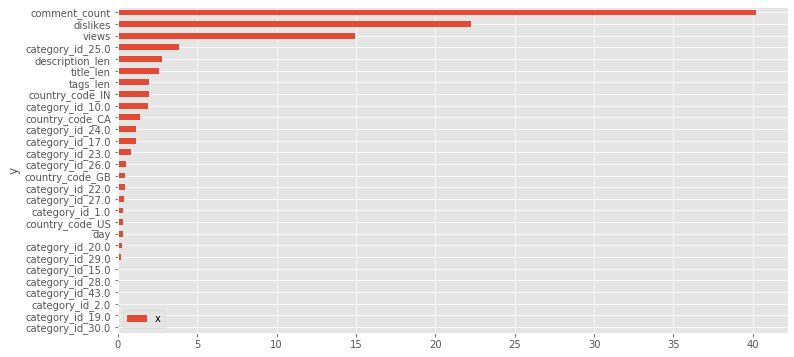

In [92]:
CB = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4
                       )
CB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = CB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)
x=LGB.feature_name_
y=CB.feature_importances_
pd.DataFrame({'x':y,'y':x}).sort_values(by = 'x',ascending=False).set_index('y')[::-1].plot(kind='barh',figsize=(12, 6));

In [93]:
XGB = XGBRegressor(random_state=63)
XGB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = XGB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

RMSE	:  0.6310015574551118
R²	:  0.8927557987331236


In [99]:
xgb_params = {'learning_rate': 0.01, 
              'max_depth': 12,
              'subsample': 0.9,        
              'colsample_bytree': 0.9,
              'n_estimators':600, 
              'gamma':1,         
              'min_child_weight':4}   
XGB = XGBRegressor(**xgb_params, seed = 10)
XGB.fit(X_trn[CAT_NUM_COL],y_trn)
pred = XGB.predict(X_val[CAT_NUM_COL])
score(y_val,pred)

RMSE	:  0.5959782440362891
R²	:  0.9043304416231267
